In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 22})

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.models import Model, Sequential
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers import Conv1D, Dense, Input, LSTM, Embedding, Dropout, GlobalMaxPooling1D, Flatten
from keras.layers import Activation, MaxPooling1D, BatchNormalization, GRU, Bidirectional, SpatialDropout1D, Concatenate
from attention import Attention

from sklearn.metrics import accuracy_score
from sklearn.metrics import  classification_report

In [ ]:
random_raw_df = pd.read_csv('random_tweets.csv', usecols=[1], names=['tweet'])
depressed_raw_df = pd.read_csv('depressive_tweets_final.csv', usecols=[1], names=['tweet'])
train_raw_df = pd.concat([random_raw_df, depressed_raw_df])

train_raw_df.dropna(inplace=True)
train_raw_df.reset_index(drop=True, inplace=True)
train_raw_df.head(10)

,tweet
0,"I`d have responded, if I were going"
1,Sooo SAD I will miss you here in San Diego!!!
2,my boss is bullying me...
3,what interview! leave me alone
4,"Sons of ****, why couldn`t they put them on t..."
5,http://www.dothebouncy.com/smf - some shameles...
6,2am feedings for the baby are fun when he is a...
7,Soooo high
8,Both of you
9,Journey!? Wow... u just became cooler. hehe....


In [ ]:
labels = np.ones((len(train_raw_df), 1))

for i in range(len(random_raw_df)):
    labels[i] = 0

labels = to_categorical(labels)

In [ ]:
from bs4 import BeautifulSoup 
import re 

# Data Preparation 1: HTML decoding
pat1 = r'@[A-Za-z0-9]+'   # @mention
pat2 = r'https?://[A-Za-z0-9./]+' # URL
combined_pat = r'|'.join((pat1, pat2))

def tweet_cleaner(text):
    soup = BeautifulSoup(text, 'lxml')  # HTML decoding
    souped = soup.get_text()
    stripped = re.sub(combined_pat, '', souped) # URL, @mention
    try:
        clean = stripped.replace(u'ï¿½', ' ') # Latin character encoding
    except:
        clean = stripped
#     letters_only = re.sub("[^a-zA-Z]", " ", clean)  # We reserve punctuation
    lower_case = clean.lower()
    # During the letters_only process two lines above, it has created unnecessay white spaces,
    # I will tokenize and join together to remove unneccessary white spaces
#     words = tok.tokenize(lower_case)
    return lower_case

In [ ]:
print("Cleaning and parsing the tweets...\n")
clean_tweet_texts = []
for i in range(len(train_raw_df)):
    if( (i+1)%1000 == 0 ):
        print("Tweets %d of %d has been processed" % (i+1, len(train_raw_df)))
    clean_tweet_texts.append(tweet_cleaner(train_raw_df['tweet'][i]))

Cleaning and parsing the tweets...

Tweets 1000 of 9966 has been processed
Tweets 2000 of 9966 has been processed
Tweets 3000 of 9966 has been processed
Tweets 4000 of 9966 has been processed
Tweets 5000 of 9966 has been processed
Tweets 6000 of 9966 has been processed
Tweets 7000 of 9966 has been processed
Tweets 8000 of 9966 has been processed
Tweets 9000 of 9966 has been processed


In [ ]:
# save cleaned data
clean_train_df = pd.DataFrame(clean_tweet_texts, columns=['tweet'])
clean_train_df.head()

clean_train_df.to_csv('clean_tweet_char.csv', encoding='utf-8')

In [ ]:
# Delete Null row
clean_train_df = clean_train_df.dropna()

# construct a new vocabulary
alphabet = "abcdefghijklmnopqrstuvwxyz0123456789 ,;.!?:'\"/\\|_@#$%^&*~`+-=<>()[]{}"
char_dict = {}
for i, char in enumerate(alphabet):
    char_dict[char] = i + 1

tk = Tokenizer(num_words=None, char_level=True, oov_token='UNK')

# Use char_dict to replace the tk.word_index
tk.word_index = char_dict.copy()
# Add 'UNK' to the vocabulary
tk.word_index[tk.oov_token] = max(char_dict.values()) + 1

In [ ]:
x_text = clean_train_df['tweet'].values

# Convert string to index
sequences = tk.texts_to_sequences(x_text)

# See char level length
length = [len(sent) for sent in sequences]
print('The max length is: ', max(length))
print('The min length is: ', min(length))
print('The average length is: ', sum(length)/len(length))

The max length is:  285
The min length is:  0
The average length is:  69.71101745936183


In [ ]:
# Padding
sequences_pad = pad_sequences(sequences, maxlen=285, padding='post')

In [ ]:
# Shuffle data
np.random.seed(1234)
shuffle_indices = np.random.permutation(np.arange(len(labels)))
x_shuffled = sequences_pad[shuffle_indices]
labels_shuffled = labels[shuffle_indices]

In [ ]:
# Split train and test
training_rate = 0.9
train_len = int(len(labels) * training_rate)
x_train = x_shuffled[:train_len]
labels_train = labels_shuffled[:train_len]
x_test = x_shuffled[train_len:]
labels_test = labels_shuffled[train_len:]
print('Training data size is: ', x_train.shape)
print('Validation data size is: ', x_test.shape)

Training data size is:  (8969, 285)
Validation data size is:  (997, 285)


In [ ]:
vocab_size = len(tk.word_index) # 70 (69 char, 1 UNK)
embedding_dim = 50

from keras.layers import Embedding
input_size = 285

# Embedding layer Initialization
embedding_layer = Embedding(vocab_size + 1,
                            embedding_dim,
                            input_length=input_size)

### Baseline Logistic Regression

In [ ]:
from sklearn.linear_model import LogisticRegression

class_labels_train = np.argmax(labels_train, axis=1)
class_labels_test = np.argmax(labels_test, axis=1)

logreg = LogisticRegression(max_iter = 5000)
logreg.fit(x_train, class_labels_train)
labels_pred = logreg.predict(x_test)
accuracy = logreg.score(x_test, class_labels_test)
print("Accuracy: %.2f%%" % (accuracy*100))

Accuracy: 84.35%


In [ ]:
print(classification_report(class_labels_test, labels_pred))

              precision    recall  f1-score   support

           0       0.84      1.00      0.91       805
           1       0.93      0.20      0.33       192

    accuracy                           0.84       997
   macro avg       0.88      0.60      0.62       997
weighted avg       0.86      0.84      0.80       997



### LSTM

In [ ]:
# Model Hyperparameters
embedding_dim = 50
vocab_size = len(tk.word_index)
sequence_length = 285

In [ ]:
# Embedding layer Initialization
embedding_layer = Embedding(vocab_size + 1,
                            embedding_dim,
                            input_length=sequence_length,
                            mask_zero=True)

lstm_model = Sequential()

lstm_model.add(embedding_layer)
lstm_model.add(LSTM(300))
lstm_model.add(Dropout(0.6))
lstm_model.add(Dense(2, activation='sigmoid'))

In [ ]:
lstm_model.compile(loss='binary_crossentropy', optimizer = 'nadam', metrics=['acc'])
print(lstm_model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 285, 50)           3550      
_________________________________________________________________
lstm (LSTM)                  (None, 300)               421200    
_________________________________________________________________
dropout (Dropout)            (None, 300)               0         
_________________________________________________________________
dense (Dense)                (None, 2)                 602       
Total params: 425,352
Trainable params: 425,352
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
# Train model with Early Stopping
earlystopper = EarlyStopping(monitor='val_loss', patience=2, verbose=1)

hist = lstm_model.fit(x_train, labels_train, batch_size=32, \
                      epochs=30, callbacks=[earlystopper], \
                      validation_split=0.2, shuffle=True, verbose=1)

Epoch 1/30
225/225 [==============================] - 206s 916ms/step - loss: 0.4390 - acc: 0.8297 - val_loss: 0.4448 - val_acc: 0.8378
Epoch 2/30
225/225 [==============================] - 213s 947ms/step - loss: 0.3541 - acc: 0.8641 - val_loss: 0.3915 - val_acc: 0.8411
Epoch 3/30
225/225 [==============================] - 209s 930ms/step - loss: 0.3432 - acc: 0.8737 - val_loss: 0.3089 - val_acc: 0.9080
Epoch 4/30
225/225 [==============================] - 205s 911ms/step - loss: 0.3331 - acc: 0.8778 - val_loss: 0.2687 - val_acc: 0.9069
Epoch 5/30
225/225 [==============================] - 203s 901ms/step - loss: 0.3633 - acc: 0.8663 - val_loss: 0.3449 - val_acc: 0.8595
Epoch 6/30
225/225 [==============================] - 208s 923ms/step - loss: 0.3339 - acc: 0.8715 - val_loss: 0.2834 - val_acc: 0.9019
Epoch 00006: early stopping


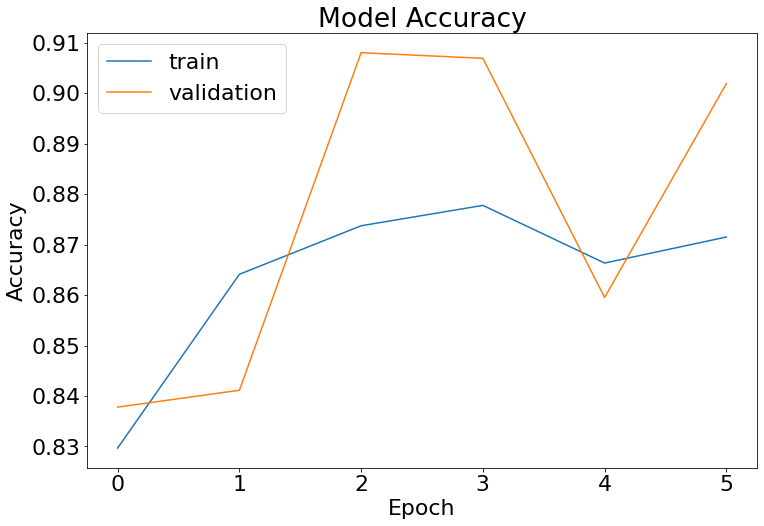

In [ ]:
plt.figure(figsize=(12,8))
plt.plot(hist.history['acc'])
plt.plot(hist.history['val_acc'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'validation'], loc='best')
plt.show()

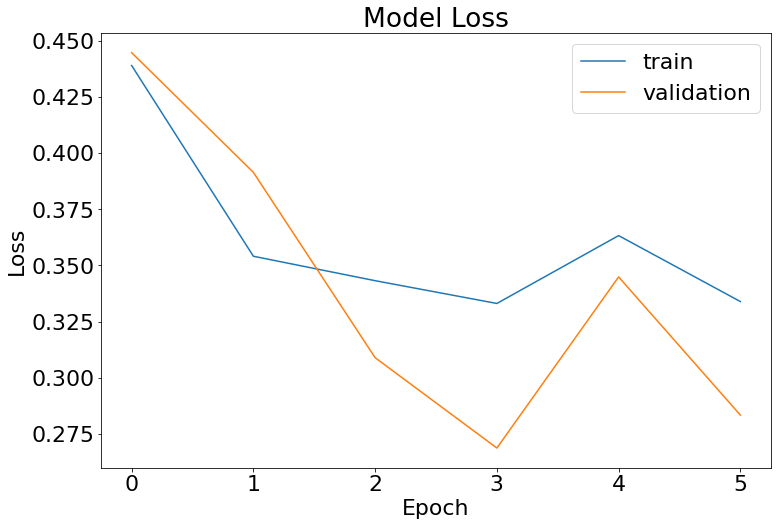

In [ ]:
plt.figure(figsize=(12,8))
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'validation'], loc='best')
plt.show()

In [ ]:
labels_pred = lstm_model.predict(x_test)
labels_pred = np.round(labels_pred)
accuracy = accuracy_score(labels_test, labels_pred)
print("Accuracy: %.2f%%" % (accuracy*100))

Accuracy: 89.37%


In [ ]:
print(classification_report(labels_test, labels_pred, labels=np.unique(labels_pred)))
lstm_model.save('lstm-char.h5')

              precision    recall  f1-score   support

         0.0       0.89      0.99      0.94       805
         1.0       0.91      0.52      0.66       192

   micro avg       0.89      0.90      0.90       997
   macro avg       0.90      0.75      0.80       997
weighted avg       0.90      0.90      0.88       997
 samples avg       0.90      0.90      0.90       997



### CNN

In [ ]:
cnn_model = Sequential()

cnn_model.add(embedding_layer)
cnn_model.add(Conv1D(filters=128, kernel_size=5, padding='same', activation='relu'))
cnn_model.add(GlobalMaxPooling1D())
cnn_model.add(Dropout(0.5))
cnn_model.add(Dense(10, activation='relu'))
cnn_model.add(Dense(2, activation='sigmoid'))

In [ ]:
cnn_model.compile(loss='binary_crossentropy', optimizer = 'nadam', metrics=['acc'])
print(cnn_model.summary())

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 285, 50)           3550      
_________________________________________________________________
conv1d (Conv1D)              (None, 285, 128)          32128     
_________________________________________________________________
global_max_pooling1d (Global (None, 128)               0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 10)                1290      
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 22        
Total params: 36,990
Trainable params: 36,990
Non-trainable params: 0
__________________________________________________

In [ ]:
# Train model with Early Stopping
earlystopper = EarlyStopping(monitor='val_loss', patience=2, verbose=1)

hist = cnn_model.fit(x_train, labels_train, batch_size=32, \
                      epochs=30, callbacks=[earlystopper], \
                      validation_split=0.2, shuffle=True, verbose=1)

Epoch 1/30
225/225 [==============================] - 4s 18ms/step - loss: 0.2373 - acc: 0.9153 - val_loss: 0.1634 - val_acc: 0.9426
Epoch 2/30
225/225 [==============================] - 4s 19ms/step - loss: 0.1633 - acc: 0.9497 - val_loss: 0.1434 - val_acc: 0.9465
Epoch 3/30
225/225 [==============================] - 5s 20ms/step - loss: 0.1377 - acc: 0.9586 - val_loss: 0.1265 - val_acc: 0.9560
Epoch 4/30
225/225 [==============================] - 5s 20ms/step - loss: 0.1212 - acc: 0.9621 - val_loss: 0.1094 - val_acc: 0.9632
Epoch 5/30
225/225 [==============================] - 4s 20ms/step - loss: 0.1106 - acc: 0.9652 - val_loss: 0.1024 - val_acc: 0.9705
Epoch 6/30
225/225 [==============================] - 5s 20ms/step - loss: 0.1037 - acc: 0.9681 - val_loss: 0.0979 - val_acc: 0.9699
Epoch 7/30
225/225 [==============================] - 5s 22ms/step - loss: 0.0972 - acc: 0.9703 - val_loss: 0.0949 - val_acc: 0.9721
Epoch 8/30
225/225 [==============================] - 5s 23ms/step - 

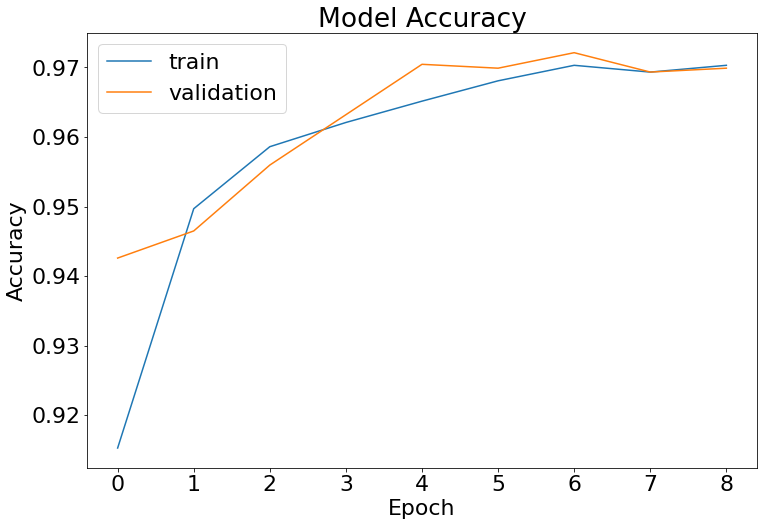

In [ ]:
plt.figure(figsize=(12,8))
plt.plot(hist.history['acc'])
plt.plot(hist.history['val_acc'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'validation'], loc='best')
plt.show()

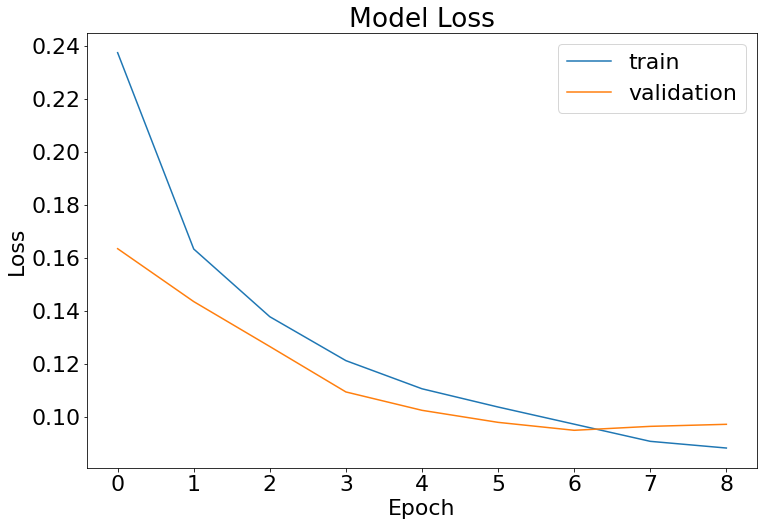

In [ ]:
plt.figure(figsize=(12,8))
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'validation'], loc='best')
plt.show()

In [ ]:
labels_pred = cnn_model.predict(x_test)
labels_pred = np.round(labels_pred)
accuracy = accuracy_score(labels_test, labels_pred)
print("Accuracy: %.2f%%" % (accuracy*100))

Accuracy: 97.09%


In [ ]:
print(classification_report(labels_test, labels_pred))
cnn_model.save('cnn-char.h5')

              precision    recall  f1-score   support

           0       0.97      1.00      0.98       805
           1       0.98      0.86      0.92       192

   micro avg       0.97      0.97      0.97       997
   macro avg       0.98      0.93      0.95       997
weighted avg       0.97      0.97      0.97       997
 samples avg       0.97      0.97      0.97       997



### LSTM-CNN

In [ ]:
# Embedding layer Initialization
embedding_layer = Embedding(vocab_size + 1,
                            embedding_dim,
                            input_length=sequence_length,
                            mask_zero=True)

lstm_cnn_model = Sequential()

lstm_cnn_model.add(embedding_layer)
lstm_cnn_model.add(Conv1D(filters=64, kernel_size=2, padding='same', activation='relu'))
lstm_cnn_model.add(MaxPooling1D(pool_size=2))
lstm_cnn_model.add(Dropout(0.5))
lstm_cnn_model.add(LSTM(300))
lstm_cnn_model.add(Dropout(0.6))
lstm_cnn_model.add(Dense(2, activation='sigmoid'))

In [ ]:
lstm_cnn_model.compile(loss='binary_crossentropy', optimizer = 'nadam', metrics=['acc'])
print(lstm_cnn_model.summary())

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 285, 50)           3550      
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 285, 64)           6464      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 142, 64)           0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 142, 64)           0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 300)               438000    
_________________________________________________________________
dropout_6 (Dropout)          (None, 300)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 2)                

In [ ]:
# Train model with Early Stopping
earlystopper = EarlyStopping(monitor='val_loss', patience=2, verbose=1)

hist = lstm_cnn_model.fit(x_train, labels_train, batch_size=32, \
                      epochs=30, callbacks=[earlystopper], \
                      validation_split=0.2, shuffle=True, verbose=1)

Epoch 1/30
225/225 [==============================] - 68s 301ms/step - loss: 0.5110 - acc: 0.8013 - val_loss: 0.4937 - val_acc: 0.8043
Epoch 2/30
225/225 [==============================] - 75s 335ms/step - loss: 0.5082 - acc: 0.8033 - val_loss: 0.4841 - val_acc: 0.8082
Epoch 3/30
225/225 [==============================] - 68s 304ms/step - loss: 0.4667 - acc: 0.8248 - val_loss: 0.4476 - val_acc: 0.8333
Epoch 4/30
225/225 [==============================] - 70s 310ms/step - loss: 0.4443 - acc: 0.8375 - val_loss: 0.4389 - val_acc: 0.8367
Epoch 5/30
225/225 [==============================] - 71s 316ms/step - loss: 0.4399 - acc: 0.8401 - val_loss: 0.4423 - val_acc: 0.8350
Epoch 6/30
225/225 [==============================] - 67s 296ms/step - loss: 0.4335 - acc: 0.8420 - val_loss: 0.4317 - val_acc: 0.8384
Epoch 7/30
225/225 [==============================] - 71s 316ms/step - loss: 0.4236 - acc: 0.8421 - val_loss: 0.4269 - val_acc: 0.8384
Epoch 8/30
225/225 [==============================] - 6

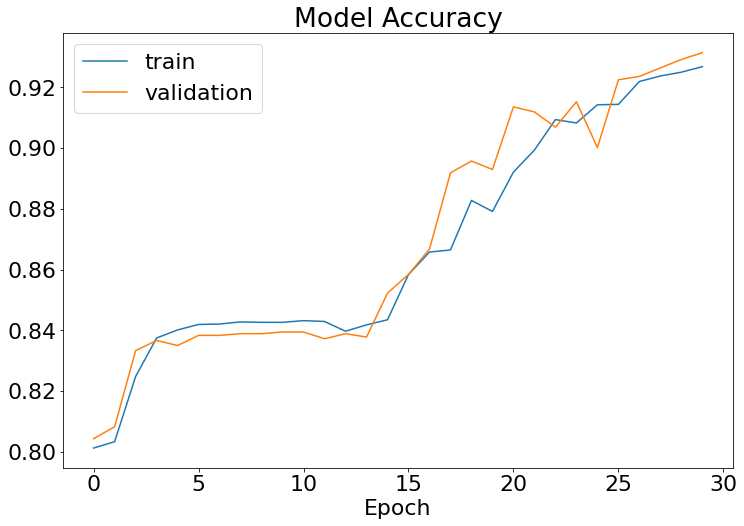

In [ ]:
plt.figure(figsize=(12,8))
plt.plot(hist.history['acc'])
plt.plot(hist.history['val_acc'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'validation'], loc='best')
plt.show()

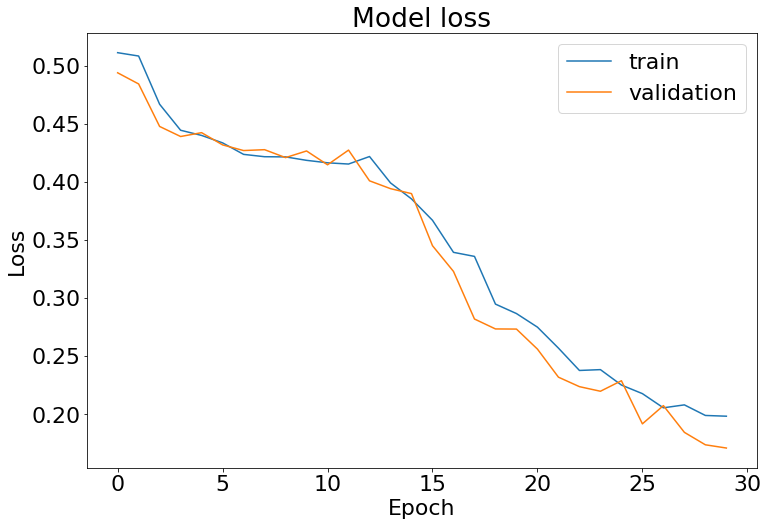

In [ ]:
plt.figure(figsize=(12,8))
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'validation'], loc='best')
plt.show()

In [ ]:
labels_pred = lstm_cnn_model.predict(x_test)
labels_pred = np.round(labels_pred)
accuracy = accuracy_score(labels_test, labels_pred)
print("Accuracy: %.2f%%" % (accuracy*100))

Accuracy: 93.48%


In [ ]:
print(classification_report(labels_test, labels_pred))
lstm_cnn_model.save('lstm-cnn-char.h5')

              precision    recall  f1-score   support

           0       0.95      0.97      0.96       805
           1       0.87      0.78      0.82       192

   micro avg       0.93      0.93      0.93       997
   macro avg       0.91      0.87      0.89       997
weighted avg       0.93      0.93      0.93       997
 samples avg       0.93      0.93      0.93       997



### BiLSTM

In [ ]:
# Embedding layer Initialization
embedding_layer = Embedding(vocab_size + 1,
                            embedding_dim,
                            input_length=sequence_length,
                            mask_zero=True)

bilstm_model = Sequential()

bilstm_model.add(embedding_layer)
bilstm_model.add(Bidirectional(LSTM(300)))
bilstm_model.add(Dropout(0.6))
bilstm_model.add(Dense(2, activation='sigmoid'))

In [ ]:
bilstm_model.compile(loss='binary_crossentropy', optimizer = 'nadam', metrics=['acc'])
print(bilstm_model.summary())

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_7 (Embedding)      (None, 285, 50)           3550      
_________________________________________________________________
bidirectional_1 (Bidirection (None, 600)               842400    
_________________________________________________________________
dropout_8 (Dropout)          (None, 600)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 2)                 1202      
Total params: 847,152
Trainable params: 847,152
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
# Train model with Early Stopping
earlystopper = EarlyStopping(monitor='val_loss', patience=2, verbose=1)

#hist = model_lstm.fit(x_train, labels_train, batch_size=batch_size, epochs=40, callbacks=[earlystopper], validation_split=0.1, shuffle=True, verbose=1)
hist = bilstm_model.fit(x_train, labels_train, batch_size=32, \
                      epochs=30, callbacks=[earlystopper], \
                      validation_split=0.2, shuffle=True, verbose=1)

Epoch 1/30
225/225 [==============================] - 586s 3s/step - loss: 0.4267 - acc: 0.8311 - val_loss: 0.3853 - val_acc: 0.8406
Epoch 2/30
225/225 [==============================] - 644s 3s/step - loss: 0.3554 - acc: 0.8562 - val_loss: 0.3631 - val_acc: 0.8540
Epoch 3/30
225/225 [==============================] - 646s 3s/step - loss: 0.3029 - acc: 0.8796 - val_loss: 0.2350 - val_acc: 0.9158
Epoch 4/30
225/225 [==============================] - 667s 3s/step - loss: 0.2818 - acc: 0.8885 - val_loss: 0.4038 - val_acc: 0.8439
Epoch 5/30
225/225 [==============================] - 630s 3s/step - loss: 0.3159 - acc: 0.8739 - val_loss: 0.2814 - val_acc: 0.8974
Epoch 00005: early stopping


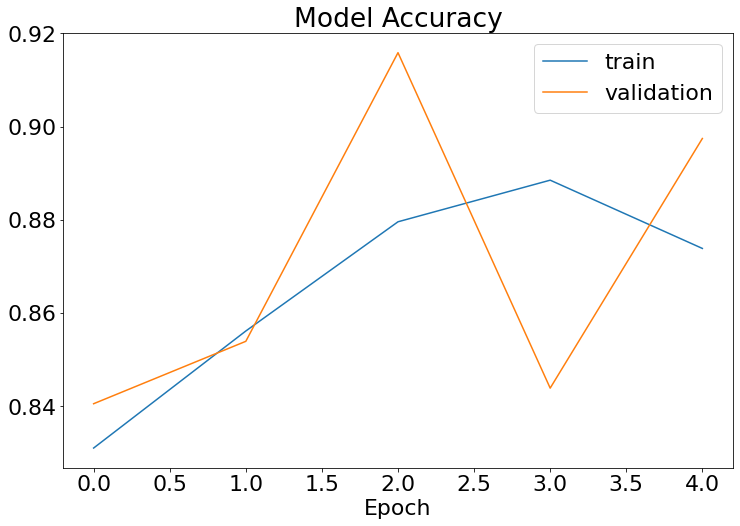

In [ ]:
plt.figure(figsize=(12,8))
plt.plot(hist.history['acc'])
plt.plot(hist.history['val_acc'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'validation'], loc='best')
plt.show()

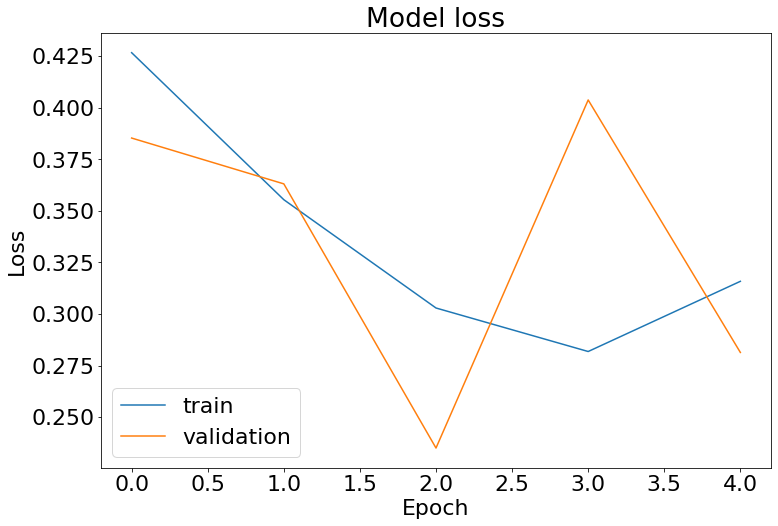

In [ ]:
plt.figure(figsize=(12,8))
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'validation'], loc='best')
plt.show()

In [ ]:
labels_pred = bilstm_model.predict(x_test)
labels_pred = np.round(labels_pred)
accuracy = accuracy_score(labels_test, labels_pred)
print("Accuracy: %.2f%%" % (accuracy*100))

Accuracy: 89.57%


In [ ]:
print(classification_report(labels_test, labels_pred))
bilstm_model.save('bilstm-char.h5')

              precision    recall  f1-score   support

           0       0.91      0.98      0.94       805
           1       0.84      0.57      0.68       192

   micro avg       0.90      0.90      0.90       997
   macro avg       0.87      0.77      0.81       997
weighted avg       0.89      0.90      0.89       997
 samples avg       0.90      0.90      0.90       997



### GRU

In [ ]:
# Embedding layer Initialization
embedding_layer = Embedding(vocab_size + 1,
                            embedding_dim,
                            input_length=sequence_length,
                            mask_zero=True)

gru_model = Sequential()

gru_model.add(embedding_layer)
gru_model.add(SpatialDropout1D(0.2))
gru_model.add(Bidirectional(GRU(300)))
gru_model.add(Dropout(0.8))
gru_model.add(Dense(2, activation='sigmoid'))

In [ ]:
gru_model.compile(loss='binary_crossentropy', optimizer = 'nadam', metrics=['acc'])
print(gru_model.summary())

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_8 (Embedding)      (None, 285, 50)           3550      
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, 285, 50)           0         
_________________________________________________________________
bidirectional_2 (Bidirection (None, 600)               633600    
_________________________________________________________________
dropout_9 (Dropout)          (None, 600)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 2)                 1202      
Total params: 638,352
Trainable params: 638,352
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
# Train model with Early Stopping
earlystopper = EarlyStopping(monitor='val_loss', patience=2, verbose=1)

#hist = model_lstm.fit(x_train, labels_train, batch_size=batch_size, epochs=40, callbacks=[earlystopper], validation_split=0.1, shuffle=True, verbose=1)
hist = gru_model.fit(x_train, labels_train, batch_size=32, \
                      epochs=30, callbacks=[earlystopper], \
                      validation_split=0.2, shuffle=True, verbose=1)

Epoch 1/30
225/225 [==============================] - 451s 2s/step - loss: 0.4271 - acc: 0.8325 - val_loss: 0.3658 - val_acc: 0.8528
Epoch 2/30
225/225 [==============================] - 552s 2s/step - loss: 0.3583 - acc: 0.8591 - val_loss: 0.3162 - val_acc: 0.8645
Epoch 3/30
225/225 [==============================] - 566s 3s/step - loss: 0.2684 - acc: 0.8962 - val_loss: 0.2203 - val_acc: 0.9153
Epoch 4/30
225/225 [==============================] - 566s 3s/step - loss: 0.2312 - acc: 0.9126 - val_loss: 0.2191 - val_acc: 0.9164
Epoch 5/30
225/225 [==============================] - 557s 2s/step - loss: 0.2240 - acc: 0.9133 - val_loss: 0.3006 - val_acc: 0.9130
Epoch 6/30
225/225 [==============================] - 595s 3s/step - loss: 0.2001 - acc: 0.9254 - val_loss: 0.1764 - val_acc: 0.9398
Epoch 7/30
225/225 [==============================] - 577s 3s/step - loss: 0.1741 - acc: 0.9357 - val_loss: 0.1812 - val_acc: 0.9426
Epoch 8/30
225/225 [==============================] - 562s 2s/step - 

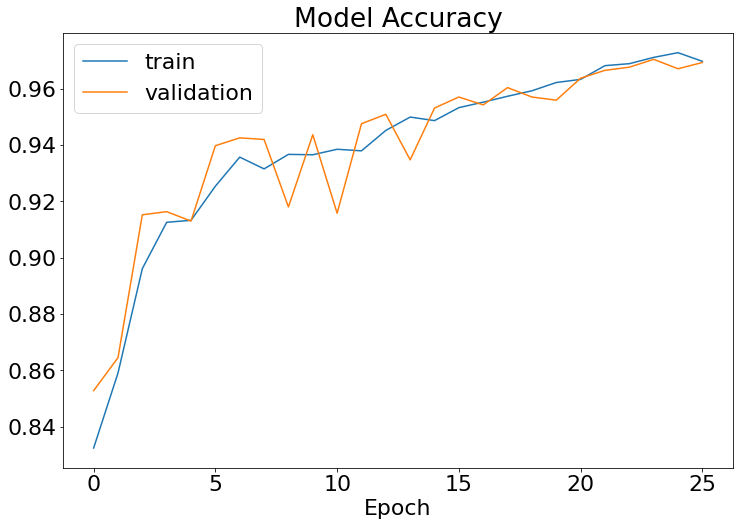

In [ ]:
plt.figure(figsize=(12,8))
plt.plot(hist.history['acc'])
plt.plot(hist.history['val_acc'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'validation'], loc='best')
plt.show()

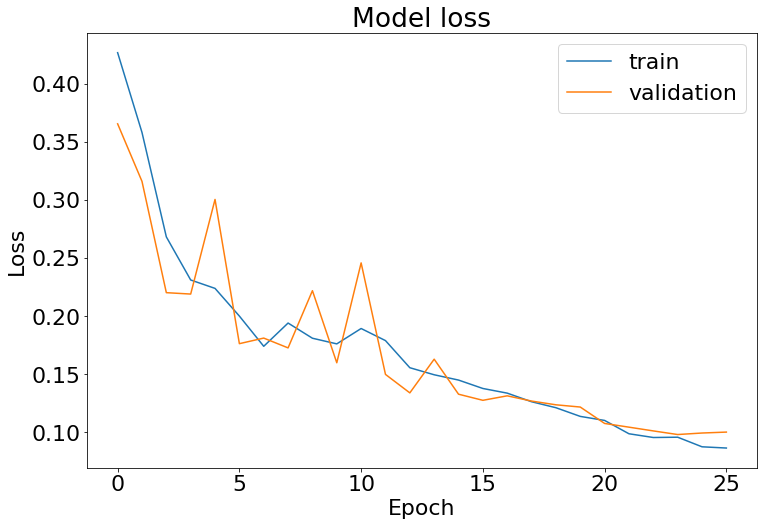

In [ ]:
plt.figure(figsize=(12,8))
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'validation'], loc='best')
plt.show()

In [ ]:
labels_pred = gru_model.predict(x_test)
labels_pred = np.round(labels_pred)
accuracy = accuracy_score(labels_test, labels_pred)
print("Accuracy: %.2f%%" % (accuracy*100))

Accuracy: 96.49%


In [ ]:
print(classification_report(labels_test, labels_pred, labels=np.unique(labels_pred)))
gru_model.save('gru-char.h5')

              precision    recall  f1-score   support

         0.0       0.97      0.99      0.98       805
         1.0       0.96      0.85      0.90       192

   micro avg       0.96      0.96      0.96       997
   macro avg       0.96      0.92      0.94       997
weighted avg       0.96      0.96      0.96       997
 samples avg       0.96      0.96      0.96       997



### Attention-Based BiLSTM+CNN Model

In [ ]:
# Model Hyperparameters
embedding_dim = 50
vocab_size = len(tk.word_index)
sequence_length = 285

In [ ]:
# Embedding layer Initialization
embedding_layer = Embedding(vocab_size + 1,
                            embedding_dim,
                            input_length=sequence_length,
                            mask_zero=True)

attention_model = Sequential()
attention_model.add(embedding_layer)
attention_model.add(Conv1D(filters=64, kernel_size=2, padding='same', activation='relu'))
attention_model.add(MaxPooling1D(pool_size=2))
attention_model.add(Dropout(0.6))
attention_model.add(Bidirectional(LSTM(300, return_sequences=True)))
attention_model.add(Attention())
attention_model.add(Dense(2, activation='sigmoid'))

In [ ]:
attention_model.compile(loss='binary_crossentropy', optimizer = 'nadam', metrics=['acc'])
print(attention_model.summary())

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 285, 50)           3550      
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 285, 64)           6464      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 142, 64)           0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 142, 64)           0         
_________________________________________________________________
bidirectional_2 (Bidirection (None, 142, 600)          876000    
_________________________________________________________________
attention_score_vec (Dense)  (None, 142, 600)          360000    
_________________________________________________________________
last_hidden_state (Lambda)   (None, 600)              

In [ ]:
# Train model with Early Stopping
earlystopper = EarlyStopping(monitor='val_loss', patience=3, verbose=1)

#hist = model_lstm.fit(x_train, labels_train, batch_size=batch_size, epochs=40, callbacks=[earlystopper], validation_split=0.1, shuffle=True, verbose=1)
hist = attention_model.fit(x_train, labels_train, batch_size=32, \
                      epochs=30, callbacks=[earlystopper], \
                      validation_split=0.2, shuffle=True, verbose=1)

Epoch 1/30
225/225 [==============================] - 8s 36ms/step - loss: 0.5255 - acc: 0.8015 - val_loss: 0.5024 - val_acc: 0.8027
Epoch 2/30
225/225 [==============================] - 7s 33ms/step - loss: 0.4907 - acc: 0.8079 - val_loss: 0.4894 - val_acc: 0.8027
Epoch 3/30
225/225 [==============================] - 7s 33ms/step - loss: 0.3533 - acc: 0.8768 - val_loss: 0.3855 - val_acc: 0.8367
Epoch 4/30
225/225 [==============================] - 8s 33ms/step - loss: 0.3035 - acc: 0.8997 - val_loss: 0.2728 - val_acc: 0.9130
Epoch 5/30
225/225 [==============================] - 8s 34ms/step - loss: 0.2719 - acc: 0.9134 - val_loss: 0.3103 - val_acc: 0.9125
Epoch 6/30
225/225 [==============================] - 8s 34ms/step - loss: 0.2531 - acc: 0.9206 - val_loss: 0.2521 - val_acc: 0.9236
Epoch 7/30
225/225 [==============================] - 8s 34ms/step - loss: 0.2337 - acc: 0.9246 - val_loss: 0.2330 - val_acc: 0.9287
Epoch 8/30
225/225 [==============================] - 8s 34ms/step - 

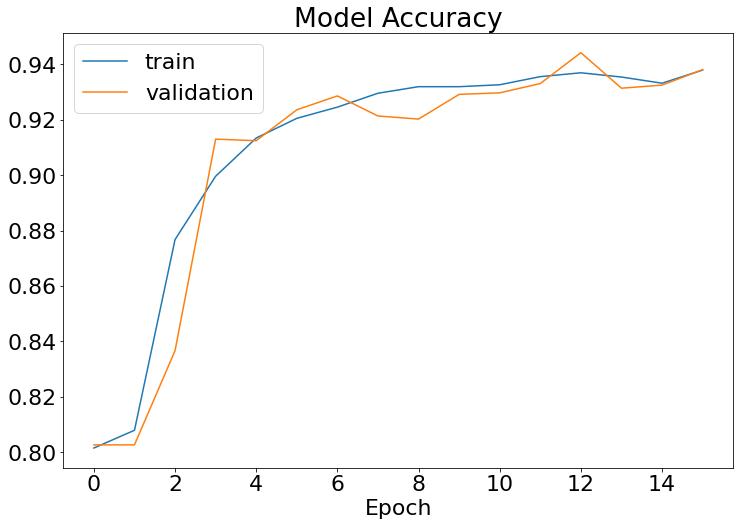

In [ ]:
plt.figure(figsize=(12,8))
plt.plot(hist.history['acc'])
plt.plot(hist.history['val_acc'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'validation'], loc='best')
plt.show()

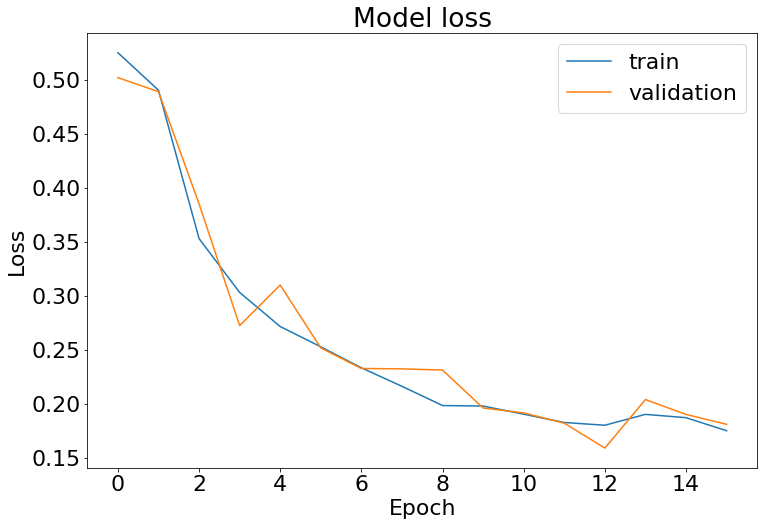

In [ ]:
plt.figure(figsize=(12,8))
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'validation'], loc='best')
plt.show()

In [ ]:
labels_pred = attention_model.predict(x_test)
labels_pred = np.round(labels_pred)
accuracy = accuracy_score(labels_test, labels_pred)
print("Accuracy: %.2f%%" % (accuracy*100))

Accuracy: 94.18%


In [ ]:
print(classification_report(labels_test, labels_pred))
attention_model.save('Detecting-Depression-Through-Tweets/attention-char.h5')

              precision    recall  f1-score   support

           0       0.93      1.00      0.97       805
           1       1.00      0.70      0.83       192

   micro avg       0.94      0.94      0.94       997
   macro avg       0.97      0.85      0.90       997
weighted avg       0.95      0.94      0.94       997
 samples avg       0.94      0.94      0.94       997

